# Uncertainty Analysis

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_18980\2841779172.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_colors = cm.get_cmap('Set2')


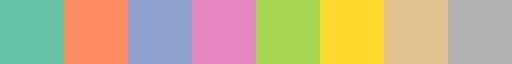

In [34]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import matplotlib.cm as cm
set2_colors = cm.get_cmap('Set2')
set2_colors

## 1 HEVs and REEVs

In [2]:
# load data
sales = pd.read_excel('data/car_sales_2007_2024_calibration.xlsx')
sales = sales[['year', 'model', 'sales', 'class', 'fuel', 'weight', 'frontB', 'rearB']].copy()

# combine others and ICEV
categories_to_merge = ['ICEV', 'others']
sales['fuel'] = sales['fuel'].apply(
    lambda x: 'ICEV & others' if x in categories_to_merge else x)

# Fill missing values in 'weight' based on mean for the same year, fuel, and class
sales['weight'] = sales.groupby(['year', 'fuel', 'class'])['weight'].transform(lambda x: x.fillna(x.mean()))
sales.dropna(subset=['model', 'weight'], inplace=True)

# expand according to sales
expanded_data = []
for index, row in sales.iterrows():
    expanded_data.extend([(row['model'], row['sales'], row['class'], row['fuel'], row['weight'], row['frontB'], row['rearB'], row['year'])] * int(row['sales'] / 100))
expanded_sales = pd.DataFrame(expanded_data, columns=['model', 'sales', 'class', 'fuel', 'weight', 'frontB', 'rearB', 'year'])

In [45]:
expanded_sales['fuel'].replace('EREV', 'REEV', inplace=True)

### Sales distribution by fuel types

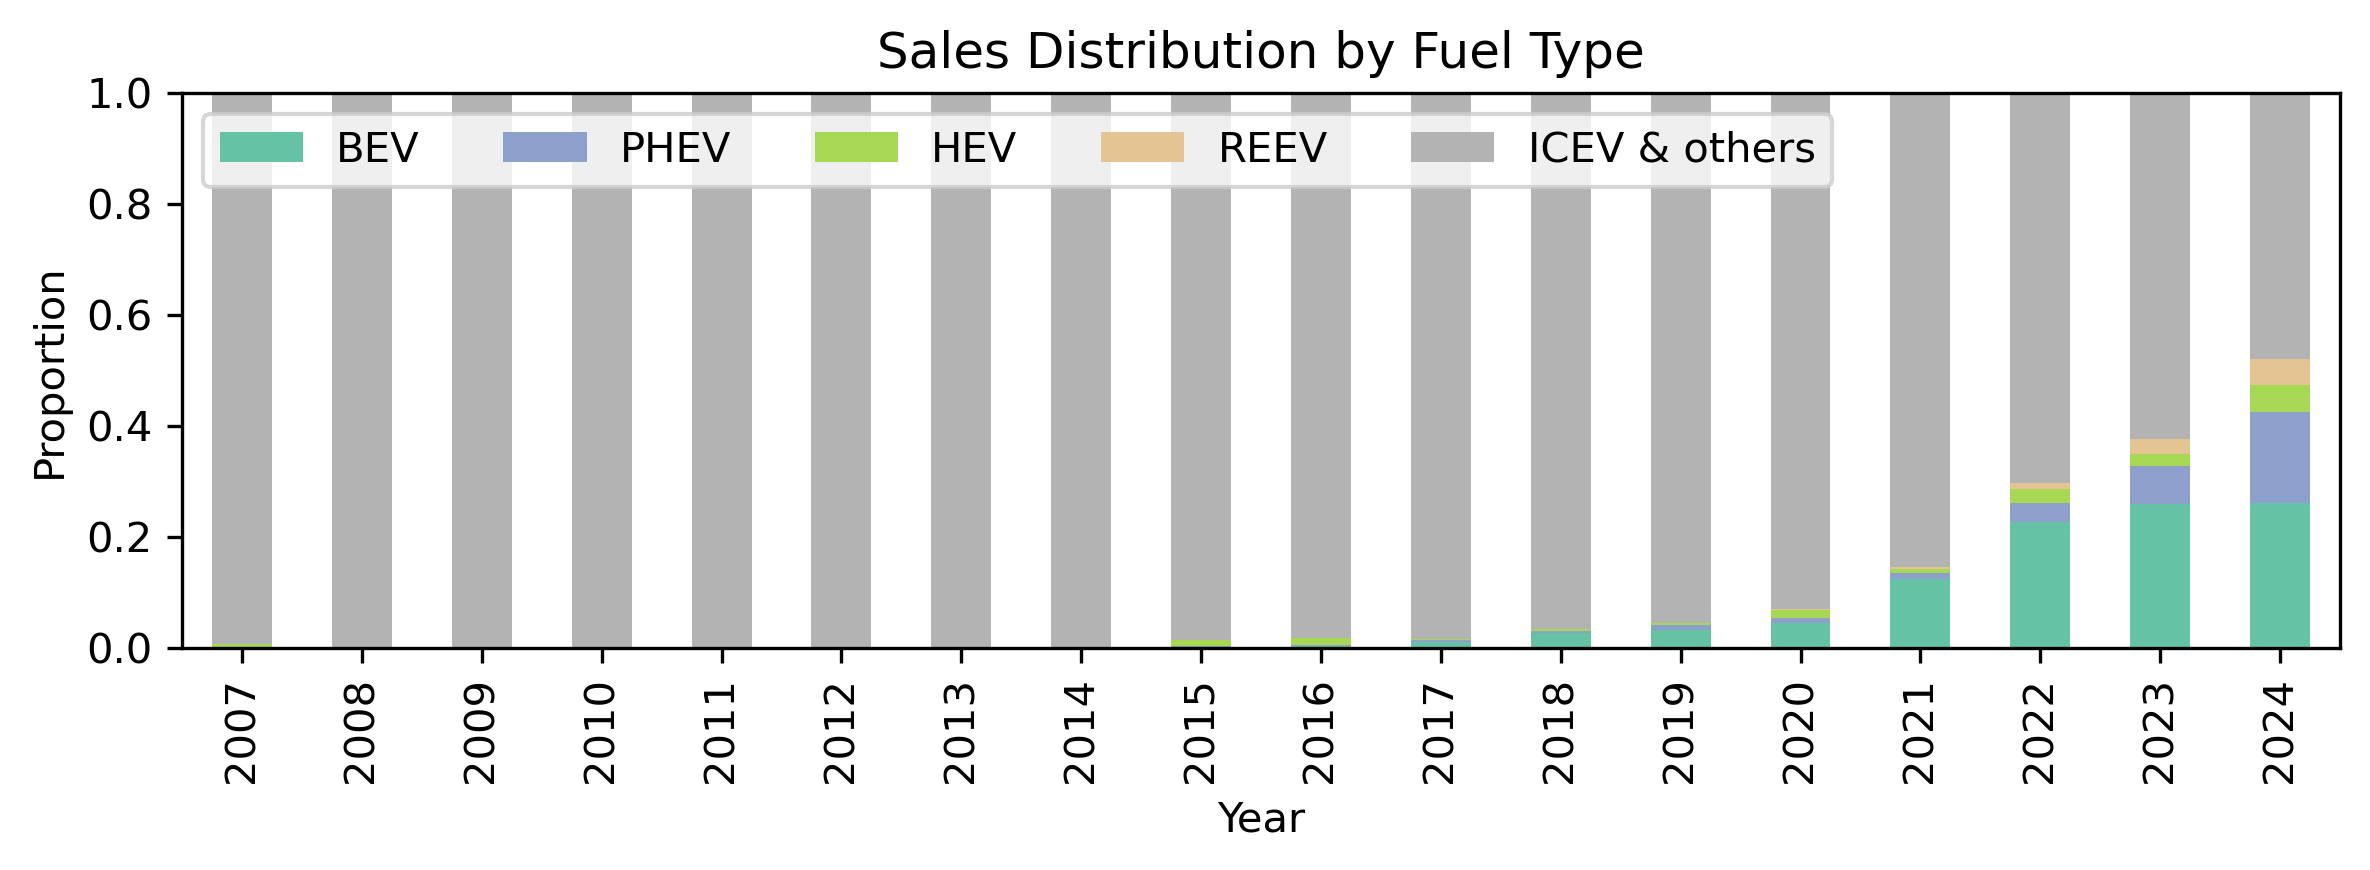

In [89]:
# Normalize to proportions
fuel_type_data = expanded_sales.groupby(['year', 'fuel']).size().unstack(fill_value=0)
fuel_type_data_normalized = fuel_type_data.div(fuel_type_data.sum(axis=1), axis=0)
fuel_type_data_normalized = fuel_type_data_normalized[['BEV', 'PHEV', 'HEV', 'REEV', 'ICEV & others']]

# Plot the stacked barplot
fuel_type_data_normalized.plot(kind='bar', stacked=True, figsize=(8,3), colormap='Set2')
plt.title('Sales Distribution by Fuel Type')
plt.xlabel('Year')
plt.ylim(0,1)
plt.ylabel('Proportion')
plt.legend(loc='upper left', ncols=5)
plt.tight_layout()
plt.show()

In [90]:
fuel_type_data_normalized

fuel,BEV,PHEV,HEV,REEV,ICEV & others
year,,,,,
2007,0.000000,0.000000,0.008334,0.000000,0.991666
2008,0.000000,0.000000,0.002069,0.000000,0.997931
2009,0.000000,0.000000,0.000017,0.000000,0.999983
2010,0.000000,0.000000,0.000000,0.000000,1.000000
2011,0.000024,0.000000,0.000000,0.000000,0.999976
2012,0.000094,0.000000,0.000125,0.000000,0.999780
2013,0.001774,0.000000,0.000236,0.000000,0.997989
2014,0.001262,0.000054,0.001430,0.000000,0.997255
2015,0.001979,0.001146,0.011253,0.000000,0.985622


### Fleet proportion

In [48]:
# define annual fleets dictionary
annual_fleets = {year: None for year in range(2016, 2025)}

# for each year, filter the expanded_sales DataFrame
for year in range(2016, 2025):
    icev = expanded_sales[
        (expanded_sales['fuel'] == 'ICEV & others') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    bev = expanded_sales[
        (expanded_sales['fuel'] == 'BEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 6)
    ]
    phev = expanded_sales[
        (expanded_sales['fuel'] == 'PHEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    hev = expanded_sales[
        (expanded_sales['fuel'] == 'HEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 6)
    ]
    erev = expanded_sales[
        (expanded_sales['fuel'] == 'REEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
   
    annual_fleets[year] = {
        'ICEV': icev,
        'BEV': bev,
        'PHEV': phev,
        'HEV' : hev,
        'REEV': erev,
    }

In [93]:
population = pd.DataFrame({
    'year': annual_fleets.keys(),
    'ICEV & others': [annual_fleets[year]['ICEV'].shape[0] for year in annual_fleets.keys()],
    'BEV': [annual_fleets[year]['BEV'].shape[0] for year in annual_fleets.keys()],
    'PHEV': [annual_fleets[year]['PHEV'].shape[0] for year in annual_fleets.keys()],
    'HEV': [annual_fleets[year]['HEV'].shape[0] for year in annual_fleets.keys()],
    'REEV': [annual_fleets[year]['REEV'].shape[0] for year in annual_fleets.keys()]
})
population['Total'] = population[['ICEV & others', 'BEV', 'PHEV', 'HEV', 'REEV']].sum(axis=1)
population['BEV%'] = population['BEV'] / population['Total']
population['PHEV%'] = population['PHEV'] / population['Total']
population['HEV%'] = population['HEV'] / population['Total']
population['REEV%'] = population['REEV'] / population['Total']
population['HEV/EV%'] = population['HEV'] / (population['BEV'] + population['PHEV'] + population['HEV'] + population['REEV'])
population['REEV/EV%'] = population['REEV'] / (population['BEV'] + population['PHEV'] + population['HEV'] + population['REEV'])

population

,year,ICEV & others,BEV,PHEV,HEV,REEV,Total,BEV%,PHEV%,HEV%,REEV%,HEV/EV%,REEV/EV%
0,2016,1844869,2364,782,7124,0,1855139,0.001274,0.000422,0.003840,0.000000,0.693671,0.000000
1,2017,2084918,5174,1534,7491,14,2099131,0.002465,0.000731,0.003569,0.000007,0.527053,0.000985
2,2018,2312147,11739,2357,8034,40,2334317,0.005029,0.001010,0.003442,0.000017,0.362382,0.001804
3,2019,2517871,18500,4138,8737,40,2549286,0.007257,0.001623,0.003427,0.000016,0.278116,0.001273
4,2020,2604053,27169,5902,10979,438,2648541,0.010258,0.002228,0.004145,0.000165,0.246786,0.009845
5,2021,2683166,52671,8124,9378,1423,2754762,0.019120,0.002949,0.003404,0.000517,0.130985,0.019875
6,2022,2726273,103987,16096,11417,4128,2861901,0.036335,0.005624,0.003989,0.001442,0.084179,0.030436
7,2023,2724373,157456,30833,15679,9884,2938225,0.053589,0.010494,0.005336,0.003364,0.073317,0.046219
8,2024,2665383,211025,68333,26140,20575,2991456,0.070543,0.022843,0.008738,0.006878,0.080166,0.063099


### Vehicle weight

In [64]:
penetration = pd.read_excel("data/ev_penetration.xlsx")
penetration = penetration.fillna(method='backfill')

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_18980\1683385587.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  penetration = penetration.fillna(method='backfill')


In [94]:
weights = pd.DataFrame({
    'year': annual_fleets.keys(),
    'ICEV & others': [annual_fleets[year]['ICEV']['weight'].mean() for year in annual_fleets.keys()],
    'BEV': [annual_fleets[year]['BEV']['weight'].mean() for year in annual_fleets.keys()],
    'PHEV': [annual_fleets[year]['PHEV']['weight'].mean() for year in annual_fleets.keys()],
    'HEV': [annual_fleets[year]['HEV']['weight'].mean() for year in annual_fleets.keys()],
    'REEV': [annual_fleets[year]['REEV']['weight'].mean() for year in annual_fleets.keys()]
}).fillna(0)
weights = pd.merge(weights, penetration[['year', 'bev%']], on='year')
weights['EV (BEV & PHEV)'] = weights.apply(lambda x: x['bev%'] * x['BEV'] + (1 - x['bev%']) * x['PHEV'], axis=1)

weights = pd.merge(weights, population[['year', 'HEV/EV%', 'REEV/EV%']], on='year')
weights['EV (all)'] = weights.apply(lambda x: x['EV (BEV & PHEV)'] * (1 - x['HEV/EV%'] - x['REEV/EV%']) + x['HEV'] * x['HEV/EV%'] + x['REEV'] * x['REEV/EV%'], axis=1)

weights.set_index('year', inplace=True)
weights

,ICEV & others,BEV,PHEV,HEV,REEV,bev%,EV (BEV & PHEV),HEV/EV%,REEV/EV%,EV (all)
year,,,,,,,,,,
2016,1375.312117,1459.397631,2027.549872,1429.048287,0.000000,0.8120,1566.210252,0.693671,0.000000,1471.064991
2017,1380.117041,1287.705257,1976.016297,1454.129889,1610.000000,0.8120,1417.107733,0.527053,0.000985,1436.810362
2018,1384.722664,1343.832207,1969.227577,1486.010953,1610.000000,0.8120,1461.406536,0.362382,0.001804,1470.590823
2019,1389.961147,1398.794581,1929.503863,1525.730457,1610.000000,0.8120,1498.567926,0.278116,0.001273,1506.264132
2020,1397.706356,1412.567781,1907.781893,1553.612351,2183.447489,0.8100,1506.658462,0.246786,0.009845,1524.909234
2021,1405.343127,1452.459231,1940.672173,1633.914481,2266.971188,0.8160,1542.290412,0.130985,0.019875,1568.695117
2022,1412.481900,1498.356690,1955.013527,1811.461417,2298.815407,0.7980,1590.601371,0.084179,0.030436,1630.748440
2023,1422.026952,1550.608698,1957.340179,1848.419287,2345.828612,0.7600,1648.224253,0.073317,0.046219,1695.144457
2024,1433.701275,1585.327999,1931.299778,1814.488256,2368.469648,0.7034,1687.943228,0.080166,0.063099,1741.028636


In [95]:
(weights.loc[2024]['EV (all)'] - weights.loc[2024]['EV (BEV & PHEV)']) / weights.loc[2024]['EV (BEV & PHEV)']

0.03144975885826092

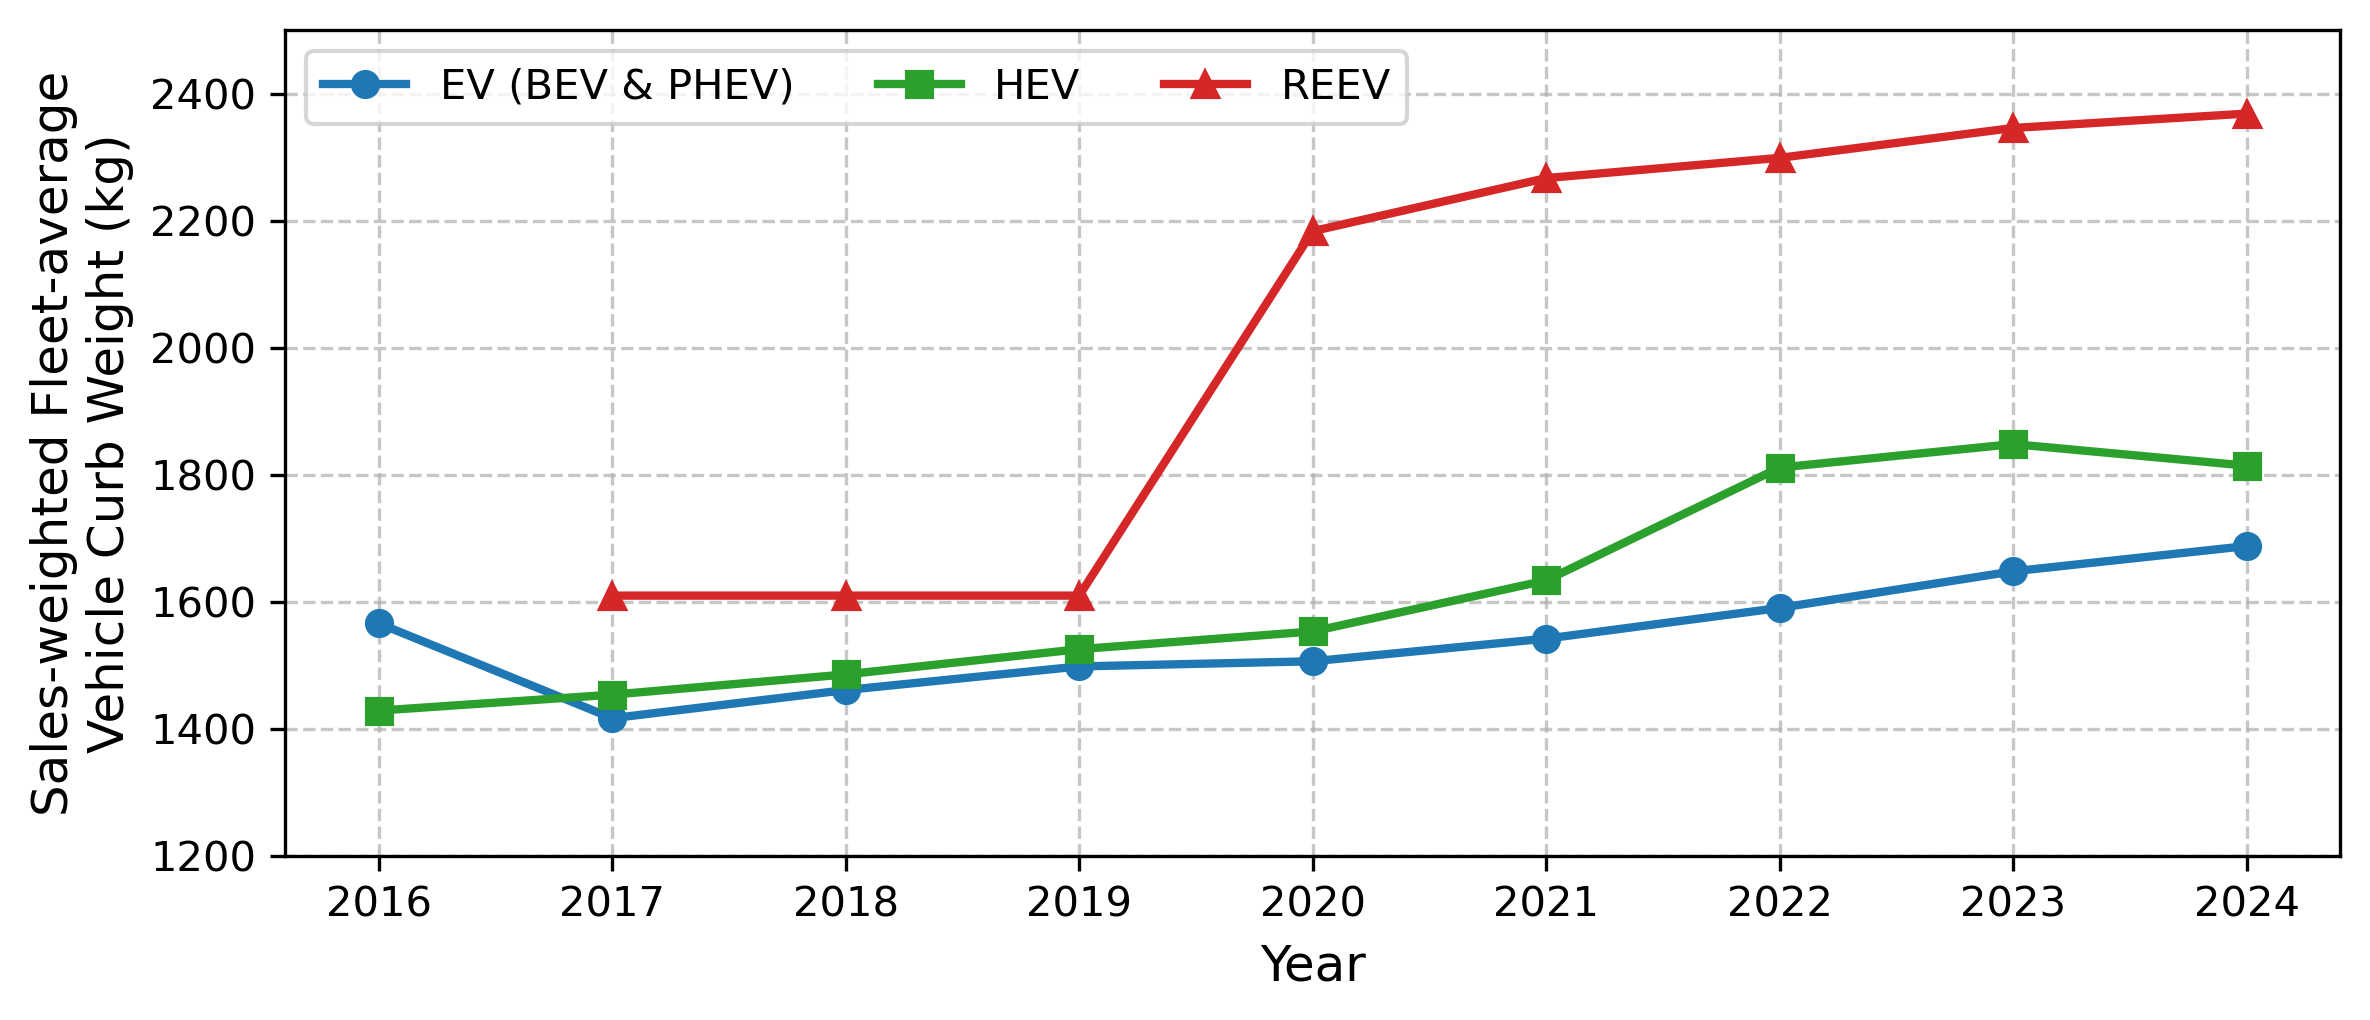

In [80]:
weights_plot = weights[['EV (BEV & PHEV)', 'HEV', 'REEV']].replace(0, pd.NA)

plt.figure(figsize=(8,3.5))
plt.plot(weights_plot.index, weights_plot['EV (BEV & PHEV)'], 
         label='EV (BEV & PHEV)', color='#1f77b4', marker='o', linewidth=2)

plt.plot(weights_plot.index, weights_plot['HEV'], 
         label='HEV', color='#2ca02c', marker='s', linewidth=2)

plt.plot(weights_plot.index[1:], weights_plot['REEV'][1:], 
         label='REEV', color='#d62728', marker='^', linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales-weighted Fleet-average\nVehicle Curb Weight (kg)', fontsize=12)
plt.xticks(weights.index.astype(int))
plt.ylim(1200, 2500)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', ncol=3)

plt.tight_layout()
plt.show()

### Vehicle-level emission factors

In [53]:
# load emission rates
with open("data/emission rates/base_opmode_er_cltc.pkl", 'rb') as f:
    base_er_cltc = pickle.load(f)

with open("data/emission rates/base_opmode_er_chengdu.pkl", 'rb') as f:
    base_er_chengdu = pickle.load(f)

# cycle
with open("data/cycles/opmode/CLTC_opmode.pkl", 'rb') as f:
    opmode_CLTC = pickle.load(f)
with open("data/cycles/opmode/Chengdu_opmode.pkl", 'rb') as f:
    opmode_Chengdu = pickle.load(f)

CLTC

In [54]:
# parameters for CLTC
cycle_cltc = pd.read_csv("data/cycles/raw/CLTC-P.csv")
durantion_cltc = cycle_cltc['Time/(s)'].max()  # s
mileage_cltc = cycle_cltc['Speed/(km/h)'].sum() / 3600  # km
opmode_dist_cltc = (opmode_CLTC['trajCount'] / opmode_CLTC['trajCount'].sum()).to_numpy()

base_ef_cltc = pd.DataFrame(columns=['ICEV EF', 'EV weak EF', 'EV strong EF'])
base_ef_cltc['ICEV EF'] = base_er_cltc['ICEV ERs'].apply(
    lambda x: (x * opmode_dist_cltc).sum() * durantion_cltc / 3600 / mileage_cltc * 1000)  # mg/km
base_ef_cltc['EV weak EF'] = base_er_cltc['EV ERs weak'].apply(
    lambda x: (x * opmode_dist_cltc).sum() * durantion_cltc / 3600 / mileage_cltc * 1000)  # mg/km
base_ef_cltc['EV strong EF'] = base_er_cltc['EV ERs strong'].apply(
    lambda x: (x * opmode_dist_cltc).sum() * durantion_cltc / 3600 / mileage_cltc * 1000)  # mg/km

In [81]:
def weight_adjust(EF, weight, assumption, weight_ref=1497):
    """
    Adjust calculated EF according to weight.
    """
    if assumption == 'linear':
        a = 1
    elif assumption == 'power':
        a = 1.9
    return EF * (weight/weight_ref)**(1/a)

def calculate_weight_adjusted_ef(cycle, weights):
    """
    Calculate weight-adjusted emission factors.
    """
    EF = pd.DataFrame()
    
    EF['EV weak EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'EV (BEV & PHEV)'], 'linear'),
        axis=1)
    EF['EV weak EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'EV (BEV & PHEV)'], 'power'),
        axis=1)
    EF['EV strong EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'EV (BEV & PHEV)'], 'linear'),
        axis=1)
    EF['EV strong EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'EV (BEV & PHEV)'], 'power'),
        axis=1)
    
    EF['HEV weak EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'HEV'], 'linear'),
        axis=1)
    EF['HEV weak EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'HEV'], 'power'),
        axis=1)
    EF['HEV strong EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'HEV'], 'linear'),
        axis=1)
    EF['HEV strong EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'HEV'], 'power'),
        axis=1)

    EF['REEV weak EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'REEV'], 'linear'),
        axis=1)
    EF['REEV weak EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV weak EF'], weights.loc[x.name, 'REEV'], 'power'),
        axis=1)
    EF['REEV strong EF linear'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'REEV'], 'linear'),
        axis=1)
    EF['REEV strong EF power'] = cycle.apply(
        lambda x: weight_adjust(x['EV strong EF'], weights.loc[x.name, 'REEV'], 'power'),
        axis=1)
    return EF

In [82]:
adjusted_ef_cltc = calculate_weight_adjusted_ef(base_ef_cltc, weights)
adjusted_ef_cltc

,EV weak EF linear,EV weak EF power,EV strong EF linear,EV strong EF power,HEV weak EF linear,HEV weak EF power,HEV strong EF linear,HEV strong EF power,REEV weak EF linear,REEV weak EF power,REEV strong EF linear,REEV strong EF power
2016,1.167883,1.143146,0.039149,0.038320,1.065605,1.089313,0.035721,0.036515,0.000000,0.000000,0.000000,0.000000
2017,1.019390,1.046220,0.034171,0.035071,1.046022,1.060518,0.035064,0.035550,1.158146,1.118905,0.038823,0.037507
2018,1.051598,1.063653,0.035251,0.035655,1.069303,1.073041,0.035845,0.035970,1.158523,1.119268,0.038835,0.037520
2019,1.099634,1.099089,0.036861,0.036843,1.119565,1.109529,0.037530,0.037193,1.181401,1.141372,0.039602,0.038261
2020,1.112317,1.108934,0.037287,0.037173,1.146981,1.126990,0.038449,0.037778,1.611968,1.348061,0.054036,0.045189
2021,1.133339,1.117451,0.037991,0.037459,1.200669,1.151913,0.040248,0.038614,1.665865,1.368581,0.055842,0.045877
2022,1.175470,1.142181,0.039404,0.038288,1.338688,1.223080,0.044875,0.041000,1.698847,1.386486,0.056948,0.046477
2023,1.229890,1.175084,0.041228,0.039391,1.379274,1.248162,0.046235,0.041840,1.750436,1.414955,0.058677,0.047431
2024,1.269203,1.199044,0.042546,0.040194,1.364355,1.245545,0.045735,0.041753,1.780907,1.433050,0.059699,0.048038


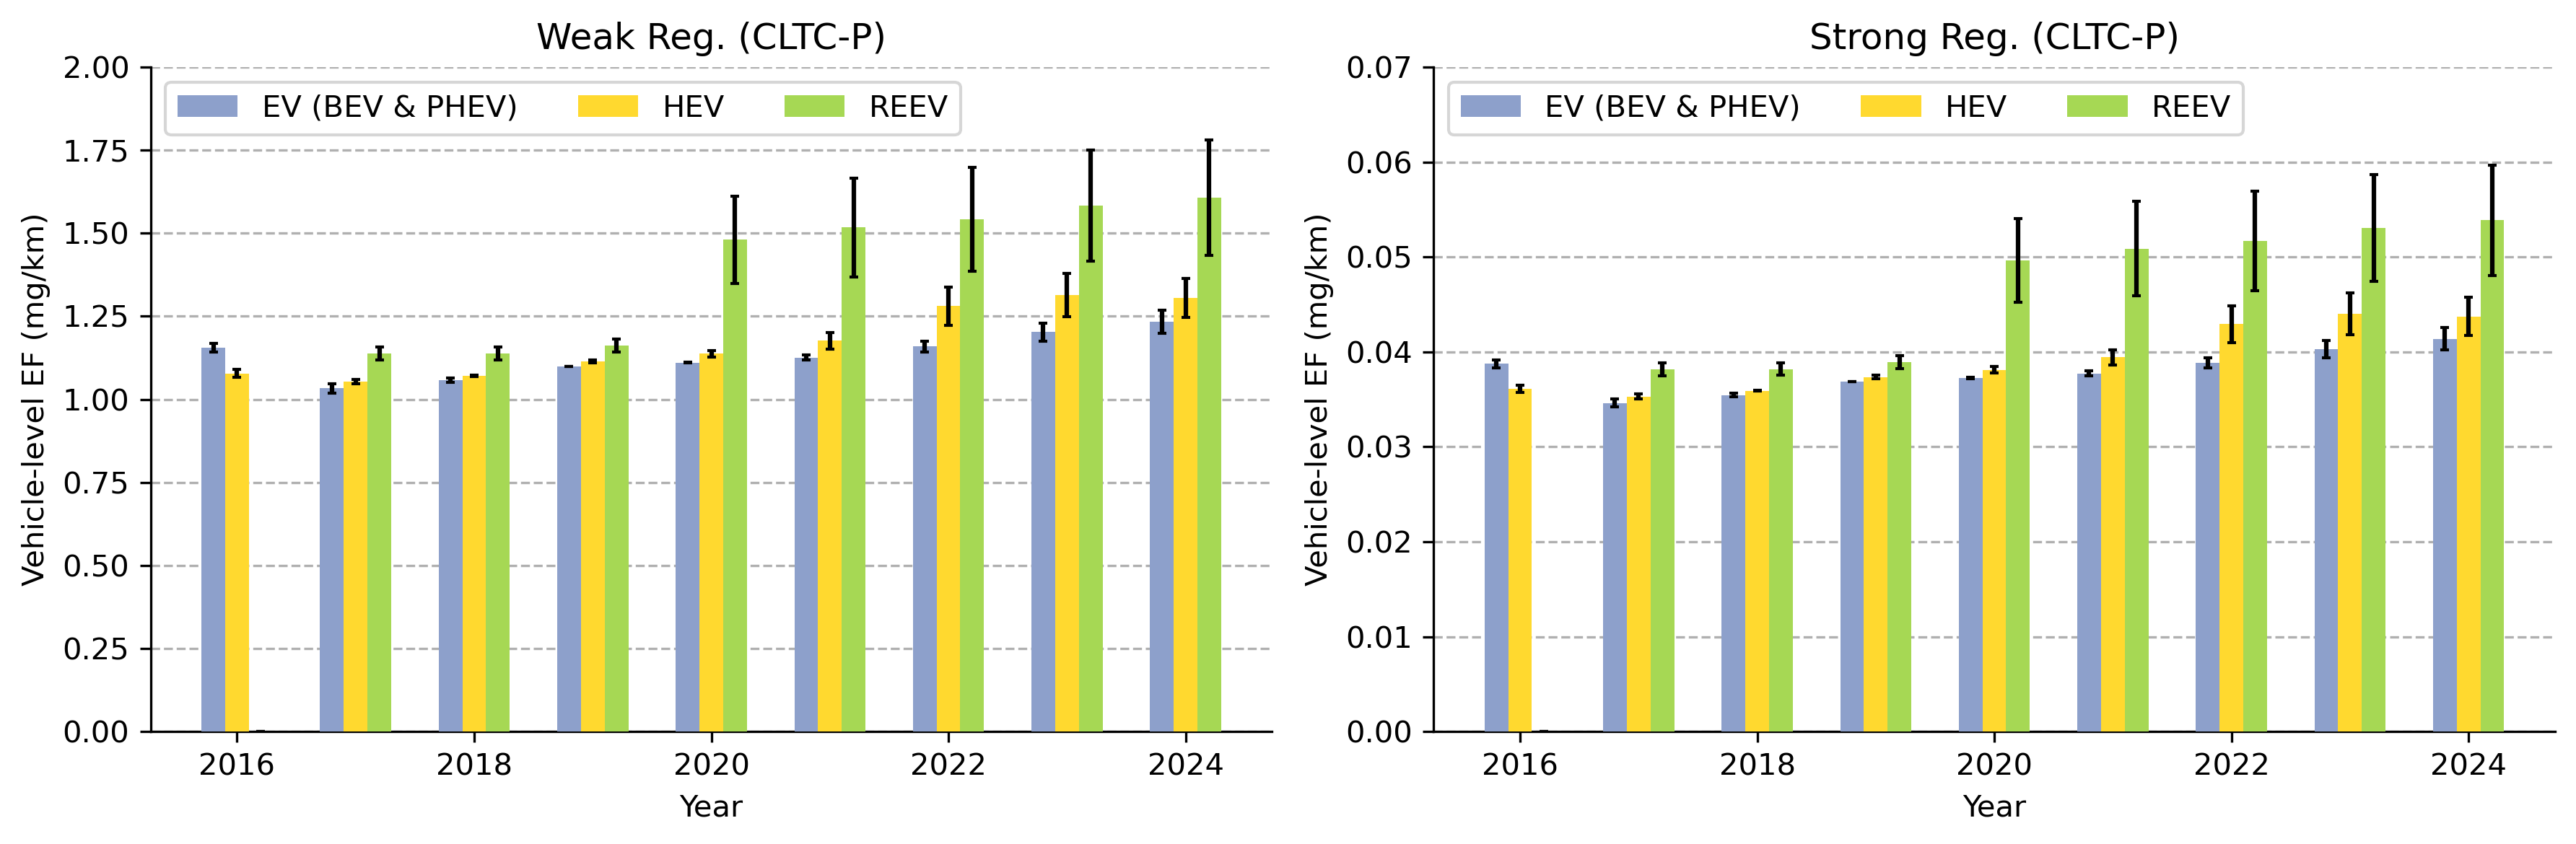

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Vehicle-level EF divided into Weak and Strong Regulation subplots
# sharey=False allows independent y-axis scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Define colors for different powertrain types
color_bev = set2_colors(2)
color_phev = set2_colors(3)
color_REEV = set2_colors(4)
color_hev = set2_colors(5)

# Bar plotting function
def bar(ax, ef, fuel, width, pos, label, color):
    """
    Plots grouped bars with error bars.
    """
    x = ef.index + width * pos
    linear = ef['%s EF linear' % fuel]
    power = ef['%s EF power' % fuel]
    
    y = (linear + power) / 2
    yerr_lower = y - np.min([linear, power], axis=0)
    yerr_upper = np.max([linear, power], axis=0) - y
    yerr = np.vstack([yerr_lower, yerr_upper])
    
    bar_obj = ax.bar(x, y, width=width, label=label, color=color, zorder=10)
    ax.errorbar(x, y, yerr=yerr, fmt='none', color='black', capsize=1.5, zorder=20)
    return bar_obj

# Width for 4 bars per cluster
width = 0.2

# --- Subplot 1: Weak Regulation ---
bar(ax1, adjusted_ef_cltc, 'EV weak',  width, -1, 'EV (BEV & PHEV)',  color_bev)
bar(ax1, adjusted_ef_cltc, 'HEV weak',  width,  0.0, 'HEV',  color_hev)
bar(ax1, adjusted_ef_cltc, 'REEV weak', width,  1, 'REEV', color_REEV)

ax1.set_title('Weak Reg. (CLTC-P)')
ax1.set_ylabel('Vehicle-level EF (mg/km)')
ax1.set_ylim(0, 2.0) # Set specific limit for Weak Reg.

# --- Subplot 2: Strong Regulation ---
bar(ax2, adjusted_ef_cltc, 'EV strong',  width, -1, 'EV (BEV & PHEV)',  color_bev)
bar(ax2, adjusted_ef_cltc, 'HEV strong',  width,  0.0, 'HEV',  color_hev)
bar(ax2, adjusted_ef_cltc, 'REEV strong', width,  1, 'REEV', color_REEV)

ax2.set_title('Strong Reg. (CLTC-P)')
ax2.set_ylabel('Vehicle-level EF (mg/km)') # Added label for clarity since scales differ
ax2.set_ylim(0, 0.07) # Set a different specific limit for Strong Reg.

# --- General Style Settings ---
for ax in (ax1, ax2):
    ax.set_xlabel('Year')
    ax.grid(axis='y', linestyle="--", zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', fontsize=10, ncols=4)

plt.tight_layout()
plt.show()